In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
df = pd.read_csv('../data/korean_stock_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']) 

File: D:/ai_team/stock_pred_strat/data/Ace Bed Company Limited_stock_data.csv
Rows: 3089
Missing Values: 0
Stats: 
       opening_price  closing_price  trading_volume
count    3089.000000    3089.000000     3089.000000
mean   112684.121075  112994.949822      459.774814
std     50023.433931   49550.204287     1391.530883
min         0.000000   29100.000000        0.000000
25%     71800.000000   72200.000000       74.000000
50%    110000.000000  110400.000000      204.000000
75%    154600.000000  154500.000000      474.600000
max    260000.000000  255000.000000    55001.000000

File: D:/ai_team/stock_pred_strat/data/Ahn-Gook Pharmaceutical Co., Ltd._stock_data.csv
Rows: 3089
Missing Values: 0
Stats: 
       opening_price  closing_price  trading_volume
count    3089.000000    3089.000000    3.089000e+03
mean    10486.057833   10471.084108    7.813845e+04
std      4522.841973    4513.834710    2.422413e+05
min      3655.220929    3655.985547    1.051770e+00
25%      6845.668213    6836.03

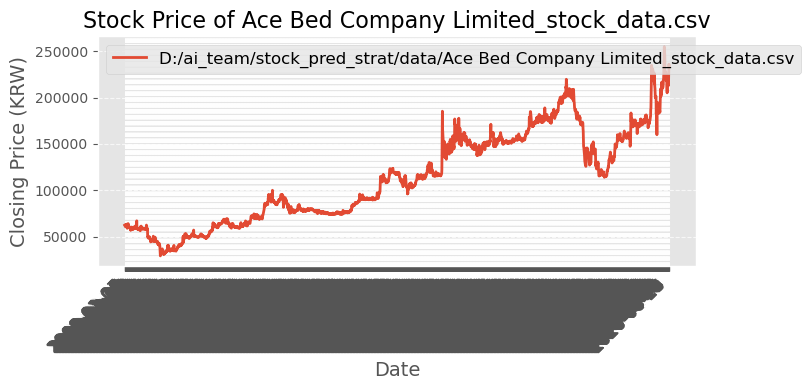

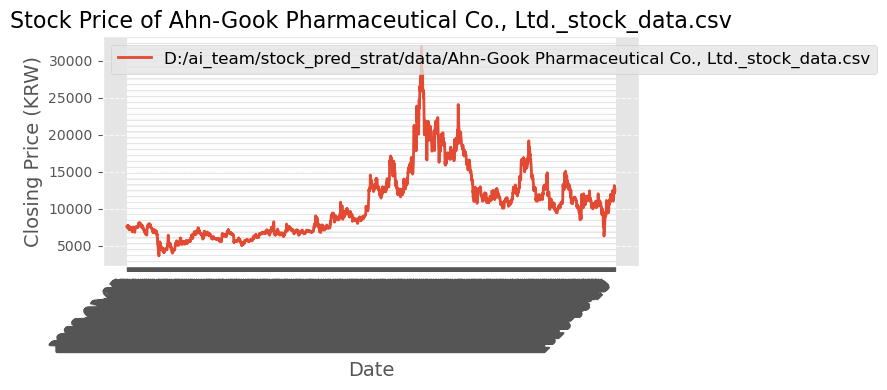

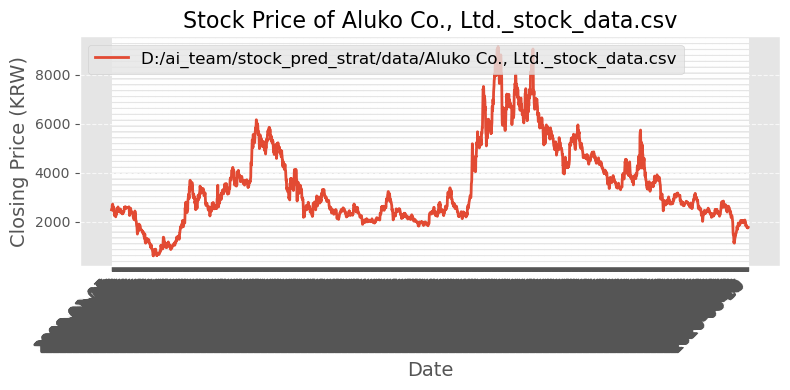

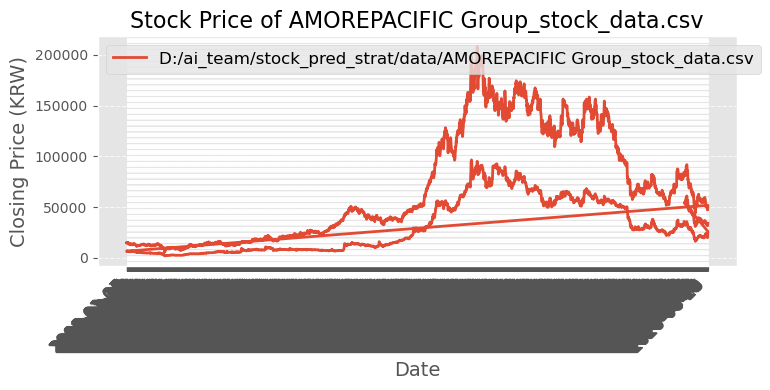

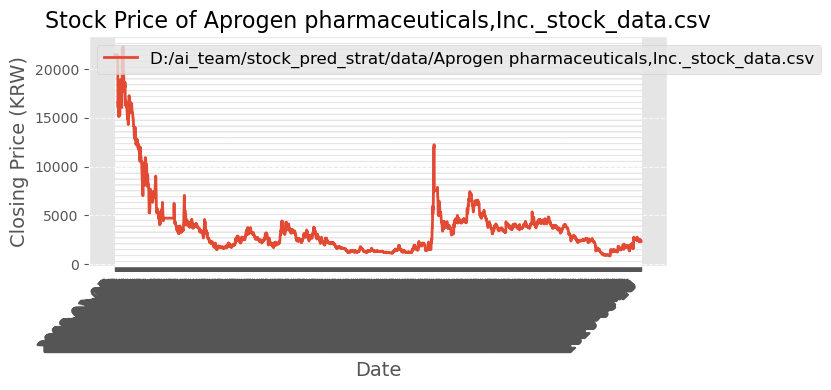

In [3]:
data_folder = 'D:/ai_team/stock_pred_strat/data/'

def evaluate_data(file_path):
    df = pd.read_csv(file_path)
    
    # check for missing vals in key cols
    missing_values = df[['opening_price', 'closing_price', 'trading_volume']].isnull().sum().sum()
    
    # verify number of rows
    num_rows = len(df)
    
    # basic stats
    stats = df[['opening_price', 'closing_price', 'trading_volume']].describe()
    
    return {
        'file': file_path,
        'missing_values': missing_values,
        'num_rows': num_rows,
        'stats': stats
    }

# initialize a list to store evaluation results
evaluations = []

for filename in os.listdir(data_folder):
    if filename.endswith('_stock_data.csv'):
        file_path = os.path.join(data_folder, filename)
        result = evaluate_data(file_path)
        
        # take only datasets with sufficient data and no missing vals
        if result['missing_values'] == 0 and result['num_rows'] > 1000: 
            evaluations.append(result)

for evaluation in evaluations:
    print(f"File: {evaluation['file']}")
    print(f"Rows: {evaluation['num_rows']}")
    print(f"Missing Values: {evaluation['missing_values']}")
    print(f"Stats: \n{evaluation['stats']}\n")

plt.style.use('ggplot')

top_companies = [eval['file'] for eval in evaluations][:5]  

for company_file in top_companies:
    df = pd.read_csv(company_file)
    plt.figure(figsize=(8, 4))
    
    plt.plot(df['timestamp'], df['closing_price'], label=company_file, linewidth=2)
    
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Closing Price (KRW)', fontsize=14)
    plt.title(f"Stock Price of {company_file.split('/')[-1]}", fontsize=16)
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=12)
    
    plt.tight_layout()
    plt.show()

filter_stocks Function:

- Missing values are removed.
- Data length: Filters out stocks with fewer than 1000 data points.
- Liquidity filter: Only stocks with a trading volume above the threshold (mean + standard deviation of trading volume) are kept.
- Volatility filter: Excludes stocks that have high price volatility based on the standard deviation of the closing price. You can adjust this threshold based on your risk tolerance.
- Iterating Through Files: The code loops through each stock's CSV file in the data folder, applies the filter_stocks function, and stores the filtered data for valid stocks.

In [4]:
# remove unknown stock files
def filter_stocks(file_path): 
    if 'unknown' in file_path.lower():
        return None
    df = pd.read_csv(file_path)
    
    df = df.dropna(subset=['opening_price', 'closing_price', 'trading_volume'])
    
    # ensure there's enough data (at least 500 rows, for example)
    if len(df) < 500:
        return None
    
    # calculate the mean and standard deviation of the trading volume
    avg_volume = df['trading_volume'].mean()
    volatility = df['closing_price'].std()
    
    # allow stocks with a reasonable trading volume and volatility
    if avg_volume < 1000 or volatility < 1:
        return None
    return df
valid_stocks = []

for filename in os.listdir(data_folder):
    if filename.endswith('_stock_data.csv'):
        file_path = os.path.join(data_folder, filename)
        stock_data = filter_stocks(file_path)
        if stock_data is not None:
            valid_stocks.append(stock_data)

print(f"Remaining valid stocks after excluding unknown stocks: {len(valid_stocks)}")

Remaining valid stocks after excluding unknown stocks: 295


In [5]:
from sklearn.preprocessing import MinMaxScaler 

def preprocess_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['closing_price_scaled'] = scaler.fit_transform(df[['closing_price']])

    # create lag features: previous 5 days closing prices
    for lag in range(1, 6):  
        df[f'closing_price_lag_{lag}'] = df['closing_price'].shift(lag)

    # drop any rows with missing lag values
    df = df.dropna(subset=[f'closing_price_lag_{lag}' for lag in range(1, 6)])
    
    # Todo: create additional features like moving averages, RSI, etc.
    return df

preprocessed_stocks = [preprocess_data(stock_df) for stock_df in valid_stocks]

for i, stock_df in enumerate(preprocessed_stocks):
    print(f"Preprocessed Stock {i+1} - {stock_df['company'].iloc[0]}:")
    print(stock_df.head(), "\n")


Preprocessed Stock 1 - Ahn-Gook Pharmaceutical Co., Ltd.:
   opening_price  highest_price  lowest_price  closing_price  trading_volume  \
5    7606.081062    7606.081062   7368.391029    7530.020251      6080.39799   
6    7273.107566    7796.010724   7273.107566    7796.010724     10829.53872   
7    7891.084026    7891.084026   7700.937423    7796.010724      7247.03980   
8    7843.174537    7881.202050   7519.940677    7615.009459      4469.39563   
9    7710.518059    7777.070003   7320.713817    7681.995798      3575.10219   

   num_of_shares                            company   timestamp  \
5       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-10   
6       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-11   
7       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-14   
8       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-15   
9       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-16   

   closing_price_scaled  closing_price_lag_1  closing_pric

In [6]:
# Clean stocks with rows containing zero values in critical columns
def clean_remaining_data(df):
    df = df[(df['opening_price'] != 0) & (df['highest_price'] != 0) & (df['trading_volume'] != 0)]
    return df

# Apply cleaning to the preprocessed stocks
cleaned_stocks = [clean_remaining_data(stock_df) for stock_df in preprocessed_stocks]

# Check if any stocks are left after cleaning
cleaned_stocks = [stock_df for stock_df in cleaned_stocks if not stock_df.empty]

# Display how many cleaned stocks remain
print(f"Remaining cleaned stocks: {len(cleaned_stocks)}")

# Optionally, print the first few rows of the cleaned data
for i, stock_df in enumerate(cleaned_stocks):
    print(f"Cleaned Stock {i+1} - {stock_df['company'].iloc[0]}:")
    print(stock_df.head(), "\n")

Remaining cleaned stocks: 295
Cleaned Stock 1 - Ahn-Gook Pharmaceutical Co., Ltd.:
   opening_price  highest_price  lowest_price  closing_price  trading_volume  \
5    7606.081062    7606.081062   7368.391029    7530.020251      6080.39799   
6    7273.107566    7796.010724   7273.107566    7796.010724     10829.53872   
7    7891.084026    7891.084026   7700.937423    7796.010724      7247.03980   
8    7843.174537    7881.202050   7519.940677    7615.009459      4469.39563   
9    7710.518059    7777.070003   7320.713817    7681.995798      3575.10219   

   num_of_shares                            company   timestamp  \
5       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-10   
6       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-11   
7       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-14   
8       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-15   
9       11500000  Ahn-Gook Pharmaceutical Co., Ltd.  2008-01-16   

   closing_price_scaled  closing_

In [7]:
from sklearn.model_selection import train_test_split

combined_data = pd.concat(cleaned_stocks, ignore_index=True)

X = combined_data[['closing_price_lag_1', 'closing_price_lag_2', 'closing_price_lag_3', 
                   'closing_price_lag_4', 'closing_price_lag_5']] 

y = combined_data['closing_price'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1598171, 5)
Test data shape: (399543, 5)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Reshape data for LSTM (LSTM expects 3D input: [samples, timesteps, features])
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to avoid overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for predicting closing price

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

predictions = model.predict(X_test)

print(f"Predictions: {predictions[:5]}")

Epoch 1/10


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24972/24972 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 6791685996544.0000 - val_loss: 10728497152.0000
Epoch 2/10
24972/24972 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 6574111719424.0000 - val_loss: 10707132416.0000
Epoch 3/10
24972/24972 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 6163514523648.0000 - val_loss: 10686134272.0000
Epoch 4/10
24972/24972 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 7423737724928.0000 - val_loss: 10665287680.0000
Epoch 5/10
24972/24972 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 5879279124480.0000 - val_loss: 10644716544.0000
Epoch 6/10
24972/24972 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 6291108397056.0000 - val_loss: 10624510976.0000
Epoch 7/10
24972/24972 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 6836460191744.0000 - val_loss: 10604703744.0000
Epoch 8/10
24972/24972 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 6442431021056.0000 - val_loss: 10584726528.0000
Epoch 9/10
24972/24972 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 6137029591040.0000 - val_loss: 10565372928

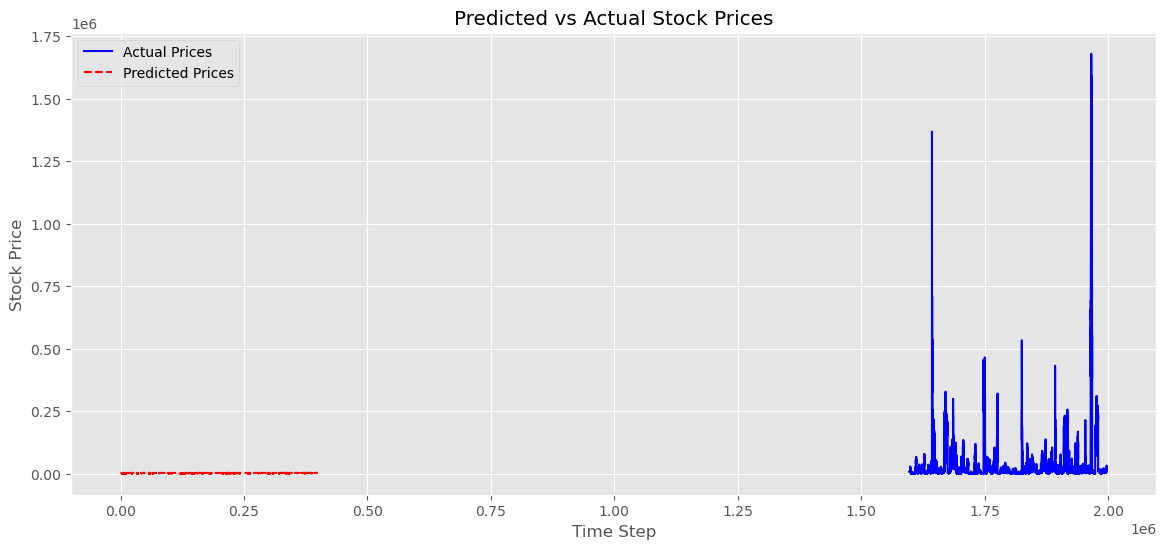

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red', linestyle='dashed')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title('Predicted vs Actual Stock Prices')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")


RMSE: 102693.82015542677
R2 Score: -0.08724992630849604
